In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import warnings
import numpy as np
import pylab as plt

from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    
    return xg, yg, zg

In [4]:
n = 512
rot = 179.5
iters = 1
nZern = 36
iz = 13
izv = -534
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [5]:
%%time
#refScan = "{0}/ref_average.ptx.csv".format(scanDir)
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_02:54:59.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_02:21:06.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_06:11:20.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=rot)

CPU times: user 7.85 s, sys: 1.59 s, total: 9.43 s
Wall time: 6.86 s


In [6]:
%%time
#sigScan = "{0}/2020_03_16_05:54:35.ptx.csv".format(scanDir) # C13=-169
#sigScan = "{0}/2020_03_16_06:18:53.ptx.csv".format(scanDir) # C13=-56
sigScan = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir) # C13=-534
xs, ys, zs = prepareData(sigScan, n=n, rot=rot)

CPU times: user 3.98 s, sys: 882 ms, total: 4.86 s
Wall time: 3.4 s


In [7]:
%%time
xmin, xmax = gridLimits(xs, xr)
ymin, ymax = gridLimits(ys, yr)
xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 1min 23s, sys: 3.25 s, total: 1min 26s
Wall time: 1min 21s


<IPython.core.display.Javascript object>


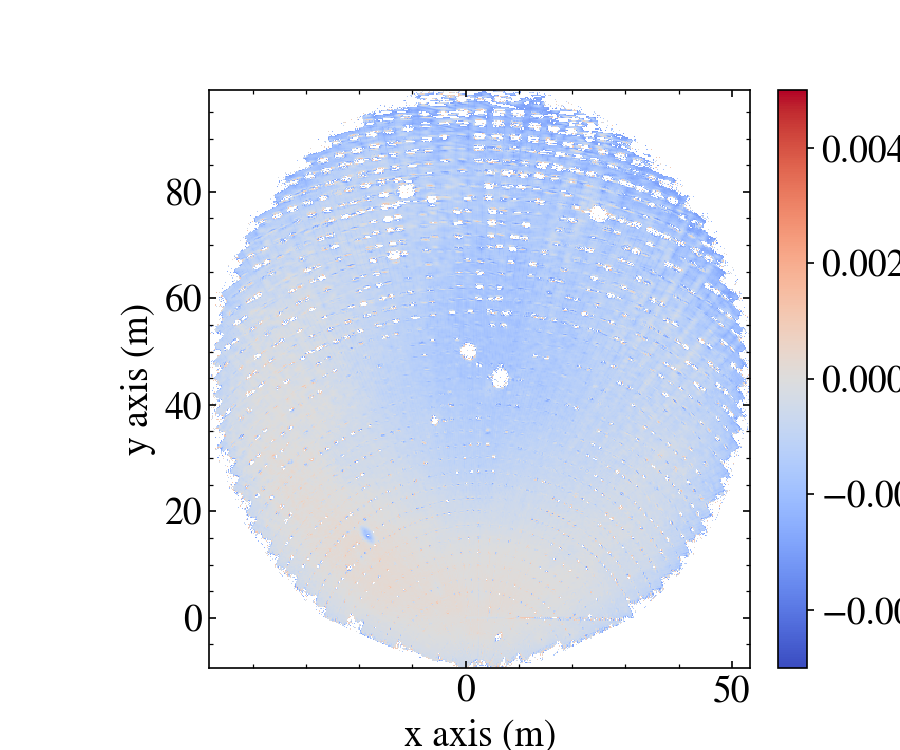

In [8]:
diff = sigma_clip(np.ma.masked_invalid(zsg - zrg))
surfacePlot(xrg, yrg, diff.T)

<IPython.core.display.Javascript object>


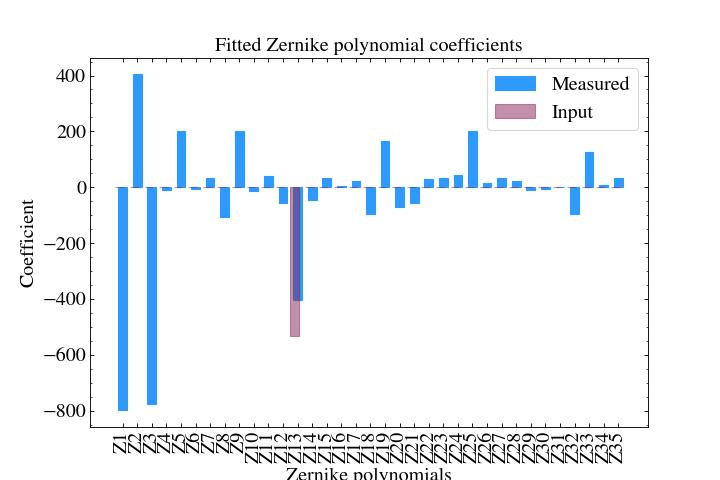

In [9]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])

<IPython.core.display.Javascript object>


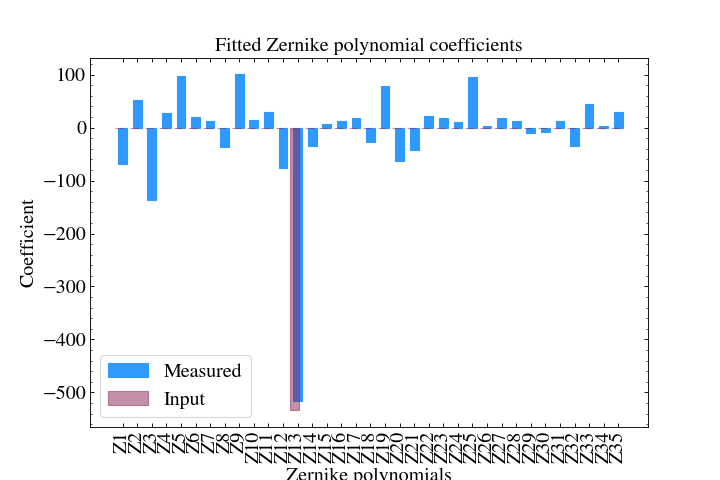

<IPython.core.display.Javascript object>


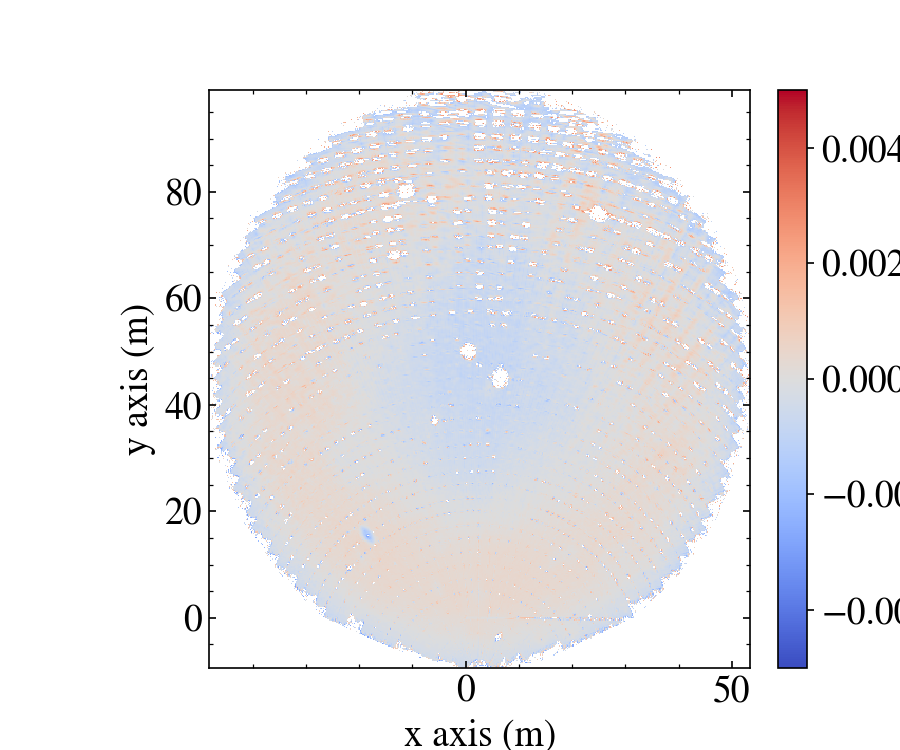

In [10]:
fl_fs_sub = np.copy(fl_fs)
fl_fs_sub[2] *= -1.
zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[:4])
diff_ = diff - zpoly_
fl_fs_ = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs_[1:36]*1e6, expected=zcoef[1:36])
surfacePlot(xrg, yrg, diff_.T)

In [11]:
fl_fs[iz]*1e6, fl_fs_[iz]*1e6

(-405.16418627311737, -517.041811210445)

<IPython.core.display.Javascript object>


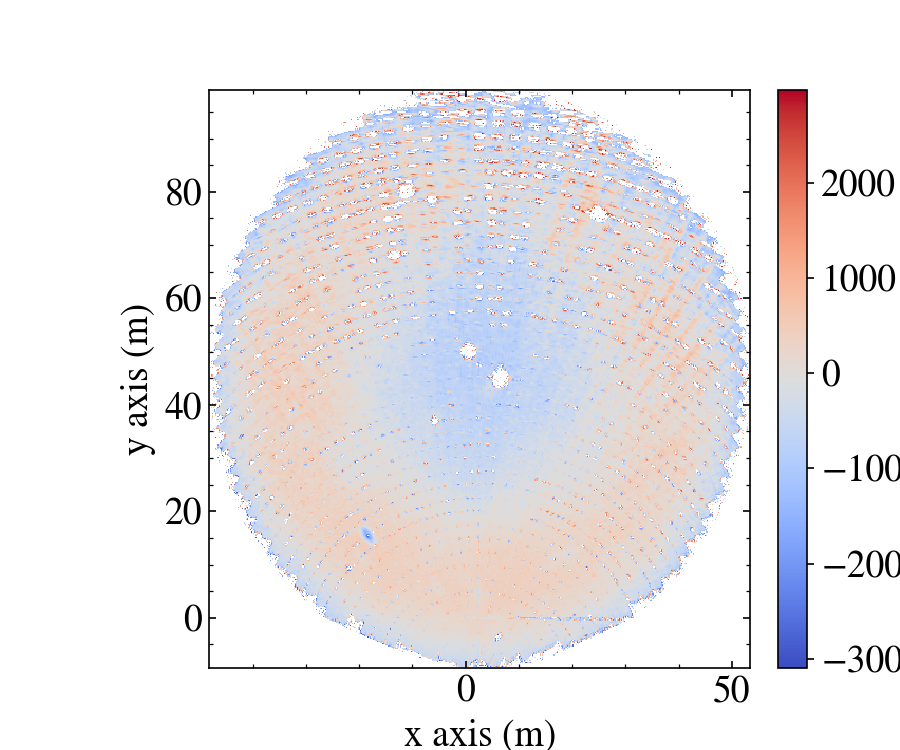

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [15]:
vmin = np.nanmin(diff_)
vmax = np.nanmax(diff_)
surfacePlot(xrg, yrg, diff_.T*1e6, vMin=vmin*1e6, vMax=vmax*1e6, midPoint=(vmin+vmax)*0.5*1e6, 
            colorbarLabel=r"$\mu$m", filename="Z13_example.pdf")